<h1>Experiment with beer3pos</h1>

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import sys
basedir = '/home/joewandy/git/metabolomics_tools'
sys.path.append(basedir)

In [13]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display, HTML

import cPickle
import random
import copy
import glob
import gzip

In [14]:
from alignment.models import HyperPars as AlignmentHyperPars
from alignment.experiment import *

<h2>Experiment Parameters</h2>

Set up all the experiment parameters

In [15]:
input_dir = '/home/joewandy/git/metabolomics_tools/alignment/input/beer3pos'
transformation_file = '/home/joewandy/git/metabolomics_tools/alignment/pos_transformations_full.yml'
gt_file = '/home/joewandy/git/metabolomics_tools/alignment/input/beer3pos/ground_truth/beer3.positive.dat'

In [16]:
hp = AlignmentHyperPars()    
hp.within_file_mass_tol = 3
hp.within_file_rt_tol = 10
hp.across_file_mass_tol = 10
hp.across_file_rt_tol = 60
hp.alpha_mass = 1
hp.dp_alpha = 1000.0
hp.beta = 0.1
hp.t = 0.0
hp.mass_clustering_n_iterations = 1000
hp.rt_clustering_nsamps = 500
hp.rt_clustering_burnin = 0

print hp

Hyperparameters across_file_mass_tol=10, across_file_rt_tol=60, alpha_mass=1, beta=0.1, dp_alpha=1000.0, mass_clustering_n_iterations=1000, matching_alpha=0.3, rt_clustering_burnin=0, rt_clustering_nsamps=500, t=0.0, within_file_mass_tol=3, within_file_rt_tol=10


In [17]:
evaluation_method = 2
n_iter = 1

In [18]:
param_list = []
for mass_tol in range(2, 7, 2):
    for rt_tol in range(5, 31, 5):
        param_list.append((mass_tol, rt_tol))

In [19]:
param_list_mwg = []
for mass_tol in range(2, 7, 2):
    for rt_tol in range(5, 31, 5):
        for group_tol in range(2, 11, 2):
            for alpha in range(0, 11, 2):
                param_list_mwg.append((mass_tol, rt_tol, group_tol, alpha/10.0))

<h2>Create the first-stage clustering for all input files -- Gibbs, mh_biggest=True</h2>

In [20]:
combined_list = load_or_create_clustering('pickles/beer3pos/clustering.p', input_dir, transformation_file, hp)

Loaded from pickles/beer3pos/clustering.p


<h2>Run experiment with beer3pos</h2>

In [21]:
n_files = 3

In [22]:
training_list = load_or_create_filelist('pickles/beer3pos/training_list.p', combined_list, n_iter, n_files)
training_list = []

Loaded from pickles/beer3pos/training_list.p
['beer3-file2.csv', 'beer3-file1.csv', 'beer3-file3.csv']


In [23]:
testing_list = load_or_create_filelist('pickles/beer3pos/testing_list.p', combined_list, n_iter, n_files)
testing_list = []

Loaded from pickles/beer3pos/testing_list.p
['beer3-file3.csv', 'beer3-file1.csv', 'beer3-file2.csv']


In [24]:
exp_results_1a = run_experiment(0, training_list, testing_list, param_list, 'pickles/beer3pos/res_match_feature.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer3pos/res_match_feature.p


In [25]:
exp_results_1b = run_experiment(1, training_list, testing_list, param_list, 'pickles/beer3pos/res_match_cluster.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer3pos/res_match_cluster.p


In [26]:
exp_results_1c = run_experiment(3, training_list, testing_list, param_list_mwg, 'pickles/beer3pos/res_mwg.p', hp, evaluation_method, transformation_file, gt_file)

Loaded from pickles/beer3pos/res_mwg.p


In [27]:
def second_stage_clustering(training_list, i):

    training_data = training_list[i]
    print "Iteration %d" % i
    print "Training on %s" % [x[0].filename for x in training_data]

    param = (hp.across_file_mass_tol, hp.across_file_rt_tol )
    selected_files = [x[0] for x in training_data]  
    selected_clusterings = [x[1] for x in training_data]            
    aligner = Aligner(selected_files, None, transformation_file, 
                           hp, verbose=False, seed=1234567890, parallel=False)
    match_mode = 2
    aligner.run(match_mode, first_stage_clustering_results=selected_clusterings)

    res = aligner.evaluate_performance(gt_file, verbose=False, print_TP=True, method=evaluation_method)
    performances = []
    for r in res:
        performances.append(param+r)
    df = pd.DataFrame(performances, columns=['mass_tol', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1', 'Threshold'])
    return df

In [28]:
# df1 = second_stage_clustering(training_list, 0)

In [29]:
# df1.to_pickle('pickles/beer3pos/df1.p')

In [30]:
df1 = pd.read_pickle('pickles/beer3pos/df1.p')

<h2>Plotting</h2>

In [31]:
sns.set_context("notebook", font_scale=2.0, rc={"lines.linewidth": 2.5})

In [32]:
def plot_density(exp_res, title):
    training_dfs = []
    for item in exp_res:
        training_data, training_df, best_training_row, match_res = item
        training_dfs.append(training_df)
    combined = pd.concat(training_dfs, axis=0)
    combined = combined.reset_index(drop=True)
#     f, ax = plt.subplots(figsize=(6, 6))    
#     sns.kdeplot(combined.Rec, combined.Prec, ax=ax)
#     sns.rugplot(combined.Rec, ax=ax)
#     sns.rugplot(combined.Prec, vertical=True, ax=ax)    
#     ax.set_xlim([0.7, 1.0])
#     ax.set_ylim([0.7, 1.0])
    g = sns.JointGrid(x="Rec", y="Prec", data=combined, xlim=(0.7, 1.0), ylim=(0.7, 1.0))
    g = g.plot_joint(sns.kdeplot)
    g = g.plot_marginals(sns.kdeplot, shade=True)
    ax = g.ax_joint
    ax.set_xlabel('Rec', fontsize=24)
    ax.set_ylabel('Prec', fontsize=24)
    ax = g.ax_marg_x
    ax.set_title(title, fontsize=24)  

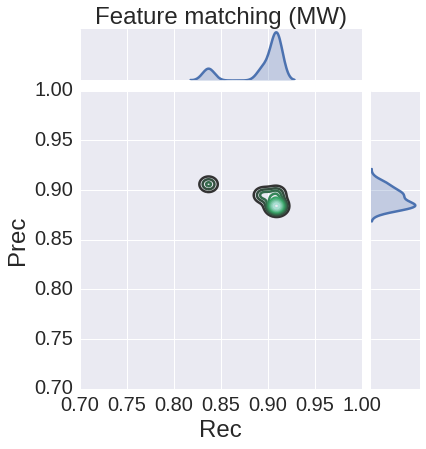

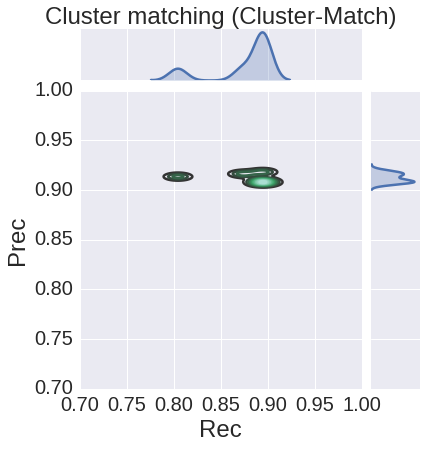

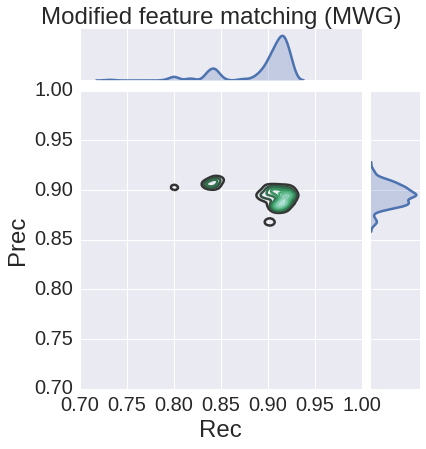

In [34]:
plot_density(exp_results_1a, 'Feature matching (MW)')
plot_density(exp_results_1b, 'Cluster matching (Cluster-Match)')
plot_density(exp_results_1c, 'Modified feature matching (MWG)')

In [35]:
print exp_results_1a

[([(<discretisation.models.PeakData object at 0x7fe33cccf3d0>, <alignment.adduct_cluster.AdductCluster object at 0x7fe33bcd9790>), (<discretisation.models.PeakData object at 0x7fe33b94ee90>, <alignment.adduct_cluster.AdductCluster object at 0x7fe33e153d10>), (<discretisation.models.PeakData object at 0x7fe33e2e35d0>, <alignment.adduct_cluster.AdductCluster object at 0x7fe33c968510>)],     mass_tol  rt_tol   TP  FP  FN      Prec       Rec        F1  Threshold
0          2       5  231  24  45  0.905882  0.836957  0.870056          1
1          2      10  247  29  29  0.894928  0.894928  0.894928          1
2          2      15  251  29  25  0.896429  0.909420  0.902878          1
3          2      20  251  33  25  0.883803  0.909420  0.896429          1
4          2      25  251  33  25  0.883803  0.909420  0.896429          1
5          2      30  251  33  25  0.883803  0.909420  0.896429          1
6          4       5  231  24  45  0.905882  0.836957  0.870056          1
7          4

In [36]:
print exp_results_1b

[([(<discretisation.models.PeakData object at 0x7fe33fef5ed0>, <alignment.adduct_cluster.AdductCluster object at 0x7fe33b8f3cd0>), (<discretisation.models.PeakData object at 0x7fe33b45f390>, <alignment.adduct_cluster.AdductCluster object at 0x7fe33b35f250>), (<discretisation.models.PeakData object at 0x7fe33a7c5b50>, <alignment.adduct_cluster.AdductCluster object at 0x7fe33a2cea50>)],     mass_tol  rt_tol   TP  FP  FN      Prec       Rec        F1  Threshold
0          2       5  222  21  54  0.913580  0.804348  0.855491          1
1          2      10  241  22  35  0.916350  0.873188  0.894249          1
2          2      15  247  22  29  0.918216  0.894928  0.906422          1
3          2      20  247  25  29  0.908088  0.894928  0.901460          1
4          2      25  247  25  29  0.908088  0.894928  0.901460          1
5          2      30  247  25  29  0.908088  0.894928  0.901460          1
6          4       5  222  21  54  0.913580  0.804348  0.855491          1
7          4

In [37]:
def plot_scatter(exp_res, idx, df, title):
    item = exp_res[idx]
    training_data, training_df, best_training_row, match_res = item
    training_df = training_df.reset_index(drop=True)
    g = sns.JointGrid(x="Rec", y="Prec", data=training_df)
    g = g.plot_joint(plt.scatter, color=".5", edgecolor="white")
    plt.figure(g.fig.number)
    plt.plot(df.Rec, df.Prec, '.r-')    
    # g = g.plot_marginals(sns.distplot, kde=False, color=".5")  
    g = g.plot_marginals(sns.kdeplot, shade=True)
    ax = g.ax_joint
    ax.set_xlabel('Rec')
    ax.set_ylabel('Prec')
    ax.set_ylim([0.7, 1.0])
    ax = g.ax_marg_x
    ax.set_title(title)    

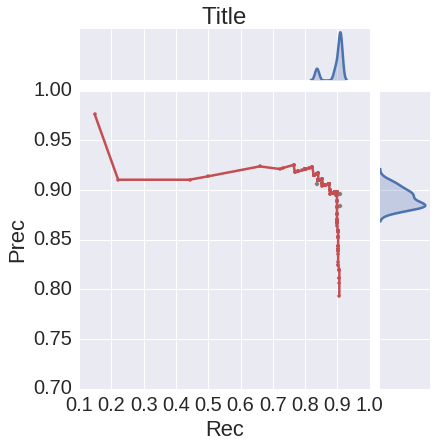

In [38]:
plot_scatter(exp_results_1a, 0, df1, 'Title')

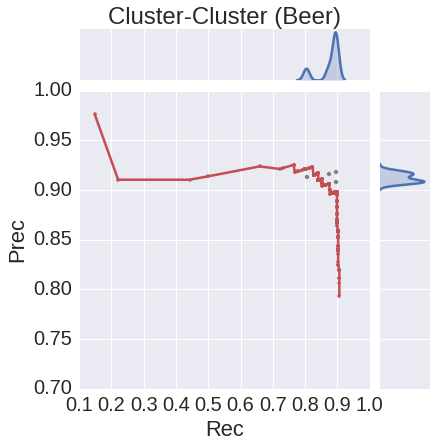

In [40]:
plot_scatter(exp_results_1b, 0, df1, 'Cluster-Cluster (Beer)')